In [1]:
# STEP 1: setup
!pip -q install plotly seaborn joblib scikit-learn --upgrade

import os, io, json, textwrap, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             roc_auc_score, confusion_matrix, RocCurveDisplay, classification_report)

pd.set_option("display.max_columns", 100)
np.random.seed(42)
os.makedirs("data", exist_ok=True)

print("✅ Libraries ready.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.4/308.4 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 97.1 MB/s eta 0:00:00
✅ Libraries ready.


In [2]:
from google.colab import files
import io

uploaded = files.upload()  # choose train.csv from the Titanic folder you extracted

# Save file to data/titanic.csv
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))
df.to_csv("data/titanic.csv", index=False)

print("✅ Saved to data/titanic.csv")
df.head()


Saving train.csv to train.csv
✅ Saved to data/titanic.csv


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# STEP 3: Basic EDA
df = pd.read_csv("data/titanic.csv")

print("Shape:", df.shape)
print("\nColumns & dtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())

# Summary statistics
df.describe(include="all").T.head(20)

# Target balance
print("\nTarget balance (Survived):")
print(df['Survived'].value_counts(normalize=True))


Shape: (891, 12)

Columns & dtypes:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Target balance (Survived):
Survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


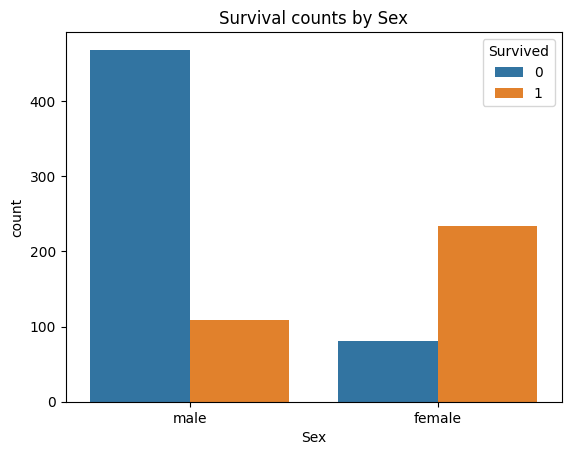

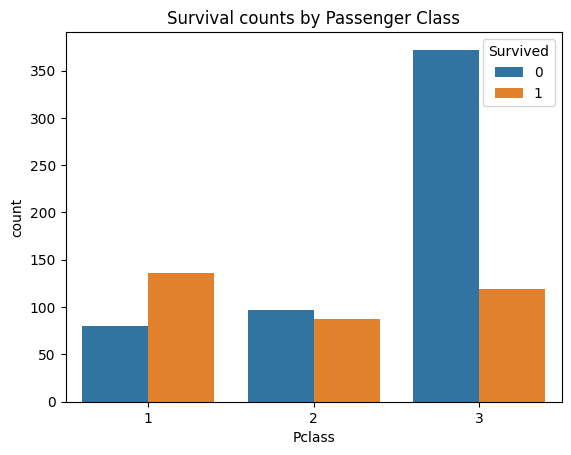

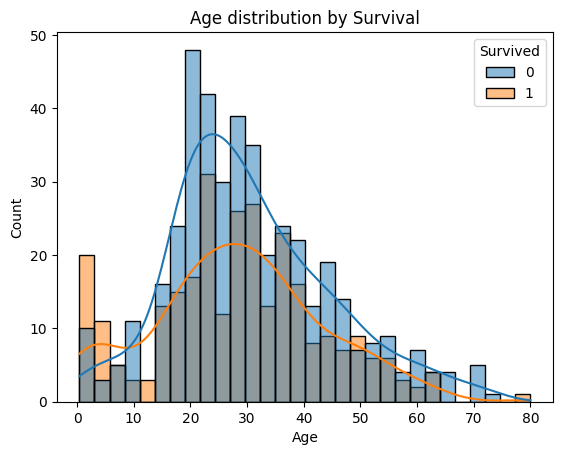

In [4]:
# STEP 4: Exploratory charts

import seaborn as sns
import matplotlib.pyplot as plt

# Survival by Sex
sns.countplot(x="Sex", hue="Survived", data=df)
plt.title("Survival counts by Sex")
plt.show()

# Survival by Passenger Class
sns.countplot(x="Pclass", hue="Survived", data=df)
plt.title("Survival counts by Passenger Class")
plt.show()

# Age distribution with Survival
sns.histplot(df, x="Age", hue="Survived", bins=30, kde=True)
plt.title("Age distribution by Survival")
plt.show()


In [5]:
# STEP 5: Feature Engineering

df = pd.read_csv("data/titanic.csv").copy()

# Extract Title from Name (Mr, Mrs, Miss, Master, Other)
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.')
df['Title'] = df['Title'].replace({
    'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs',
    'Lady':'Other','Countess':'Other','Capt':'Other','Col':'Other','Don':'Other','Dr':'Other',
    'Major':'Other','Rev':'Other','Sir':'Other','Jonkheer':'Other','Dona':'Other'
})
df['Title'] = df['Title'].where(df['Title'].isin(['Mr','Mrs','Miss','Master']), 'Other')

# Create FamilySize and IsAlone
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Features we’ll use
feature_cols = ['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked',
                'Title','FamilySize','IsAlone']
target_col = 'Survived'

df[feature_cols + [target_col]].head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone,Survived
0,3,male,22.0,1,0,7.2500,S,Mr,2,0,0
1,1,female,38.0,1,0,71.2833,C,Mrs,2,0,1
2,3,female,26.0,0,0,7.9250,S,Miss,1,1,1
3,1,female,35.0,1,0,53.1000,S,Mrs,2,0,1
4,3,male,35.0,0,0,8.0500,S,Mr,1,1,0


In [6]:
# STEP 6: Train/Test Split

from sklearn.model_selection import train_test_split

X = df[feature_cols].copy()
y = df[target_col].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training shape:", X_train.shape, "Test shape:", X_test.shape)


Training shape: (712, 10) Test shape: (179, 10)


In [7]:
# STEP 7: Preprocessing + Model Training

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate

# Define which columns are numeric vs categorical
numeric_features = ['Age','SibSp','Parch','Fare','FamilySize','IsAlone']
categorical_features = ['Pclass','Sex','Embarked','Title']

# Preprocessing steps
numeric_pre = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pre = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
    ('num', numeric_pre, numeric_features),
    ('cat', categorical_pre, categorical_features)
])

# Two models to compare
log_reg = Pipeline([
    ('pre', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

rf = Pipeline([
    ('pre', preprocess),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42))
])

# Evaluation metrics
scoring = {
    'accuracy':'accuracy',
    'f1':'f1',
    'precision':'precision',
    'recall':'recall',
    'roc_auc':'roc_auc'
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def evaluate(model, name):
    cv_res = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    row = {metric: cv_res[f'test_{metric}'].mean() for metric in scoring}
    row['model'] = name
    return row

results = pd.DataFrame([
    evaluate(log_reg, 'LogisticRegression'),
    evaluate(rf, 'RandomForest')
]).set_index('model').sort_values('roc_auc', ascending=False)

results


,accuracy,f1,precision,recall,roc_auc
model,,,,,
RandomForest,0.799183,0.735189,0.742730,0.728956,0.868652
LogisticRegression,0.823057,0.763252,0.786748,0.743704,0.866208


✅ Test metrics: {
  "accuracy": 0.8547486033519553,
  "f1": 0.803030303030303,
  "precision": 0.8412698412698413,
  "recall": 0.7681159420289855,
  "roc_auc": 0.8786561264822135,
  "chosen_model": "LogisticRegression"
}

Classification report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88       110
           1       0.84      0.77      0.80        69

    accuracy                           0.85       179
   macro avg       0.85      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179


Confusion Matrix:
 [[100  10]
 [ 16  53]]


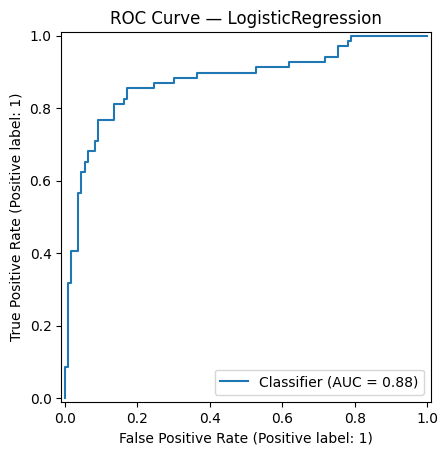

In [8]:
# STEP 8: Train best model and evaluate on test set

from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay
import matplotlib.pyplot as plt
import json

# Pick the best model (change to 'rf' if you prefer RandomForest)
best_pipe = log_reg  # Logistic Regression chosen
best_name = "LogisticRegression"

best_pipe.fit(X_train, y_train)

# Predictions
y_pred = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:,1]

# Metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

test_metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred)),
    "f1": float(f1_score(y_test, y_pred)),
    "precision": float(precision_score(y_test, y_pred)),
    "recall": float(recall_score(y_test, y_pred)),
    "roc_auc": float(roc_auc_score(y_test, y_proba)),
    "chosen_model": best_name
}

print("✅ Test metrics:", json.dumps(test_metrics, indent=2))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)

# ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve — {best_name}")
plt.show()


In [9]:
# STEP 9: Save the trained model for deployment

import joblib, json
from google.colab import files

# Save model
joblib.dump(best_pipe, "model.pkl")

# Save test metrics for later display in app
with open("metrics.json", "w") as f:
    json.dump(test_metrics, f, indent=2)

print("✅ Saved model.pkl and metrics.json")

# Download to your computer
files.download("model.pkl")
files.download("metrics.json")


✅ Saved model.pkl and metrics.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>